In [1]:
# Install wget (if not already installed)
!pip install wget

import wget
import os

# Define the Kaggle dataset download link
kaggle_dataset_url = 'https://www.kaggle.com/datasets/vyombhatia/the-three-hair-types/download?datasetVersionNumber=1'

# Define the local directory where you want to save the dataset
local_directory = 'kaggle_dataset'

# Create the local directory if it doesn't exist
os.makedirs(local_directory, exist_ok=True)

# Define the local path for the downloaded dataset file
local_file_path = os.path.join(local_directory, 'dataset.zip')  # Change the file name as needed

# Download the dataset
wget.download(kaggle_dataset_url, local_file_path)

print("Dataset downloaded successfully!")



-1 / unknownDataset downloaded successfully!


In [2]:
import os

# Replace this line with the path to your local input directory
local_input_directory = 'E:\4\hack\data\curly'

# List all files under the input directory
for dirname, _, filenames in os.walk(local_input_directory):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [3]:
!pip install torch torchvision

In [4]:
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from matplotlib import pyplot as plt
import cv2
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

In [5]:
dataset_path = 'E:\4\hack\data'

In [6]:
print(dataset_path)

E:\hack\data


In [7]:
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder

# Define the dataset path using a raw string literal (prefix 'r')
dataset_path = r'E:\4\hack\data'

# Define the transformations you want to apply
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.ToTensor()
])

# Create the ImageFolder dataset
full_dataset = ImageFolder(dataset_path, transform=transform)


In [8]:
print(len(full_dataset))

79


In [11]:
train_dataset, val_dataset = random_split(full_dataset, [59, 20])


In [12]:
batch_size = 90

In [13]:
train_dl = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_dataset, batch_size*2, num_workers=4, pin_memory=True)

In [14]:
print(full_dataset.classes)

['curly', 'straight', 'wavy']


Label : curly


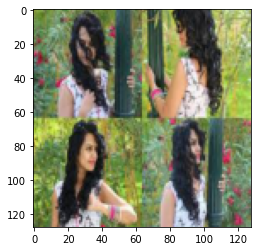

In [15]:
def display_img(img,label):
    print(f"Label : {full_dataset.classes[label]}")
    plt.imshow(img.permute(1,2,0))

#display the first image in the dataset
display_img(*full_dataset[7])

<ipython-input-16-bcefb47dc437>:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(16, 12))


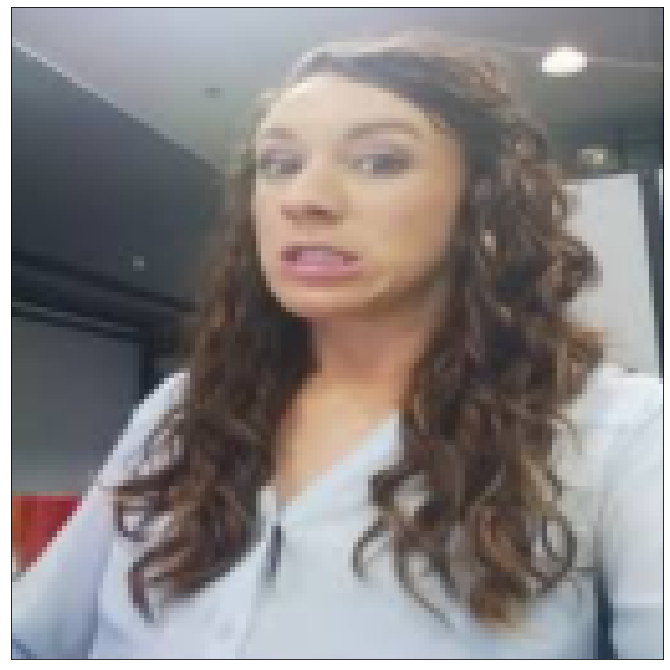

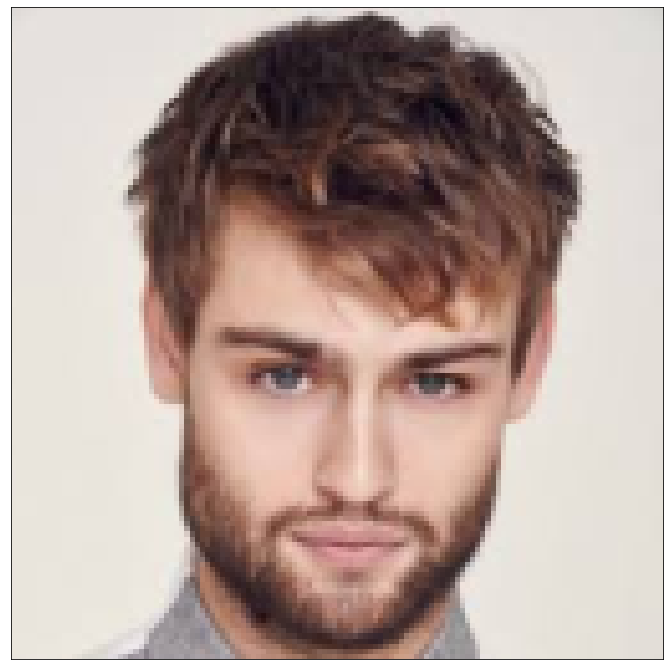

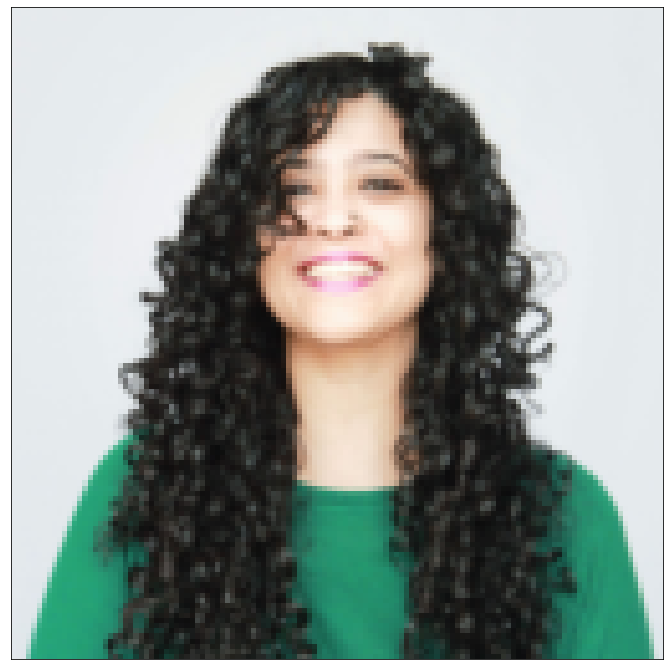

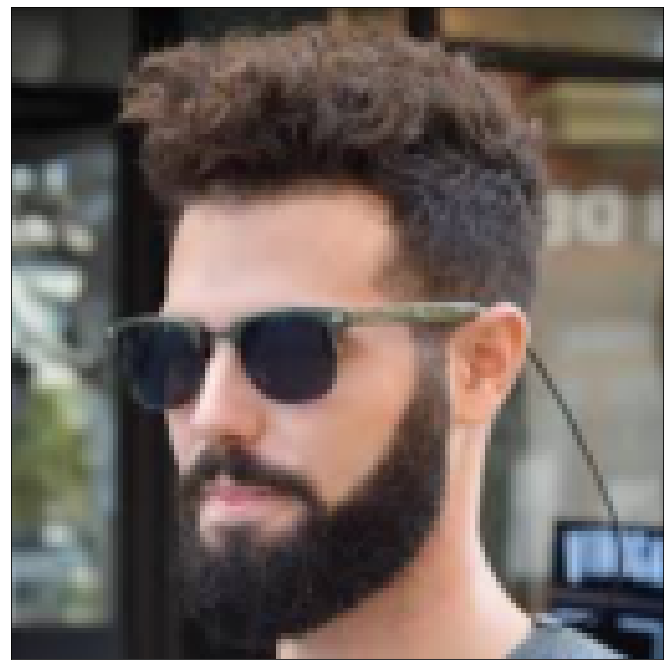

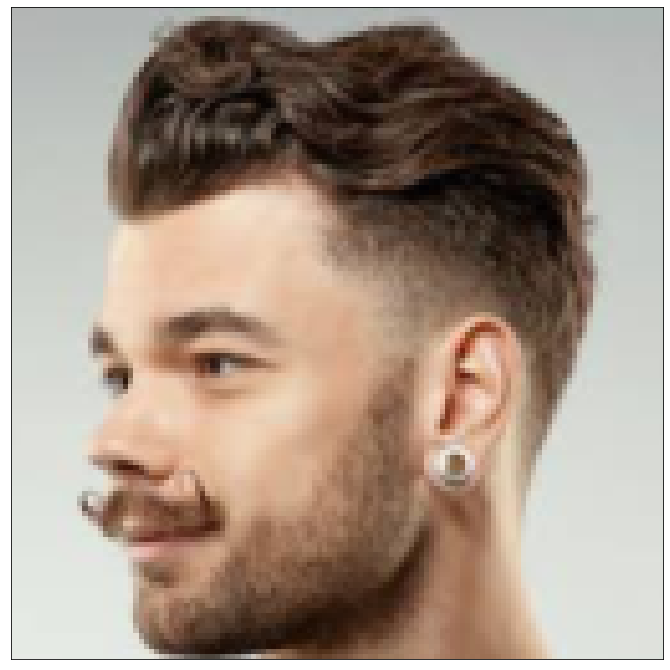

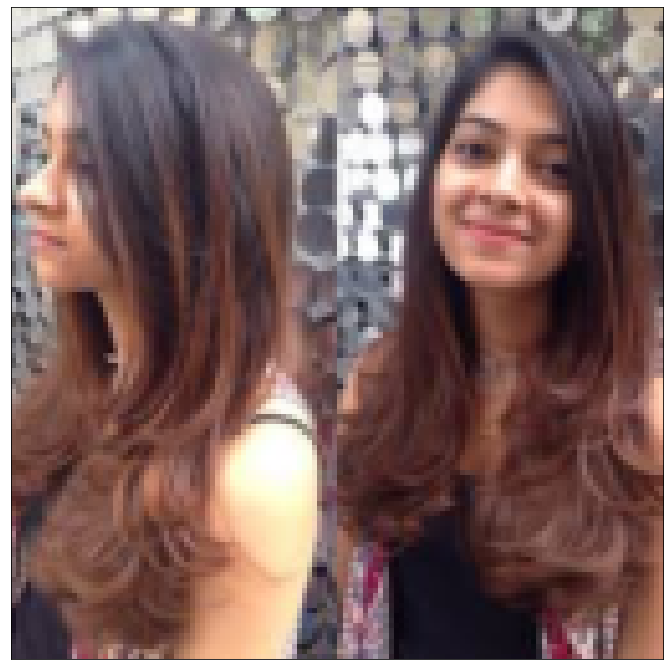

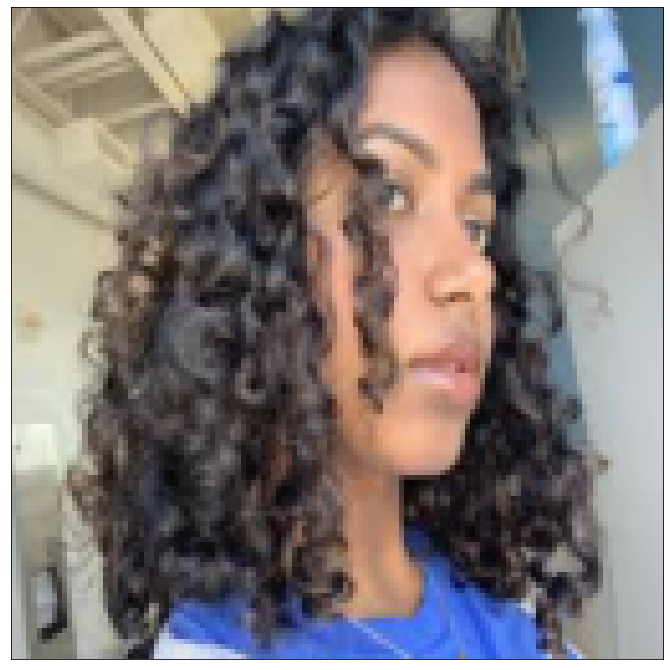

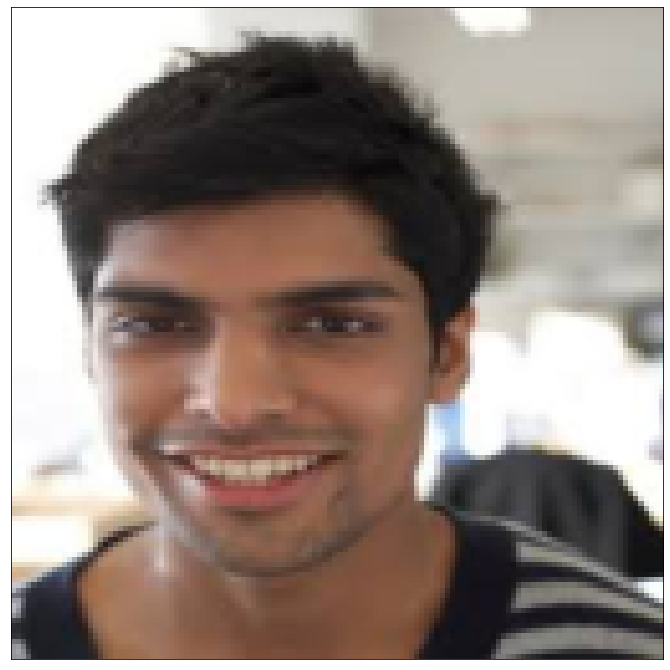

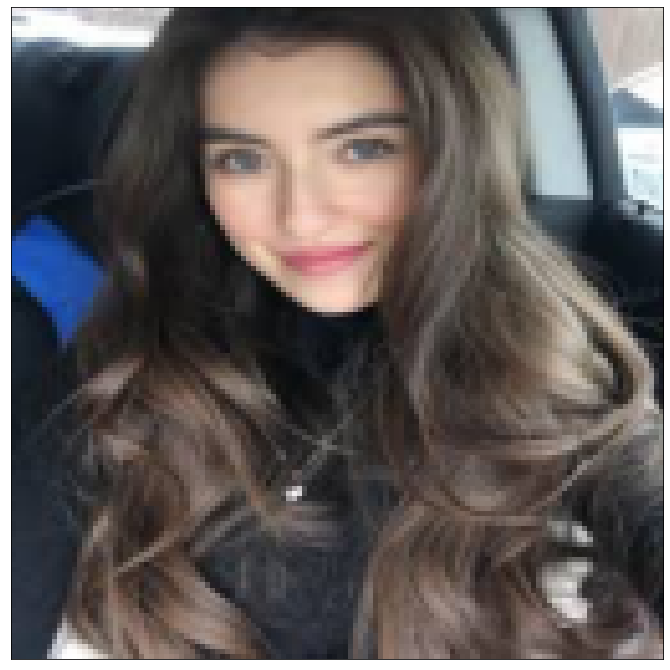

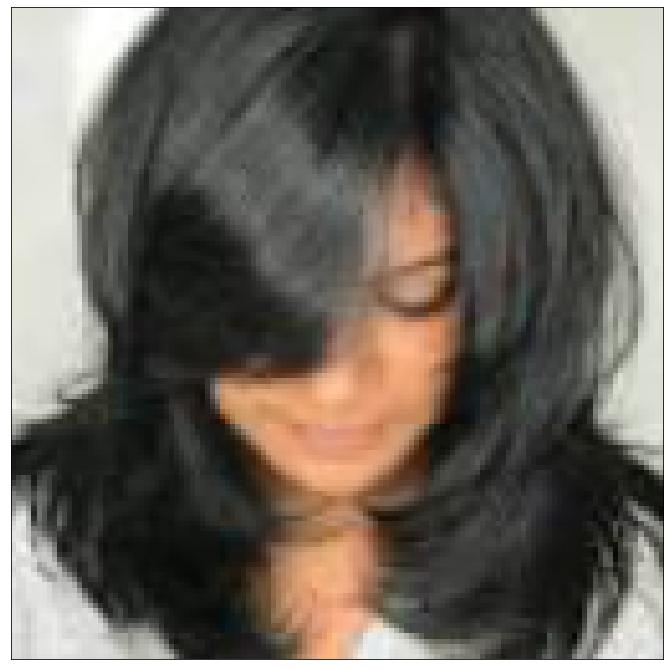

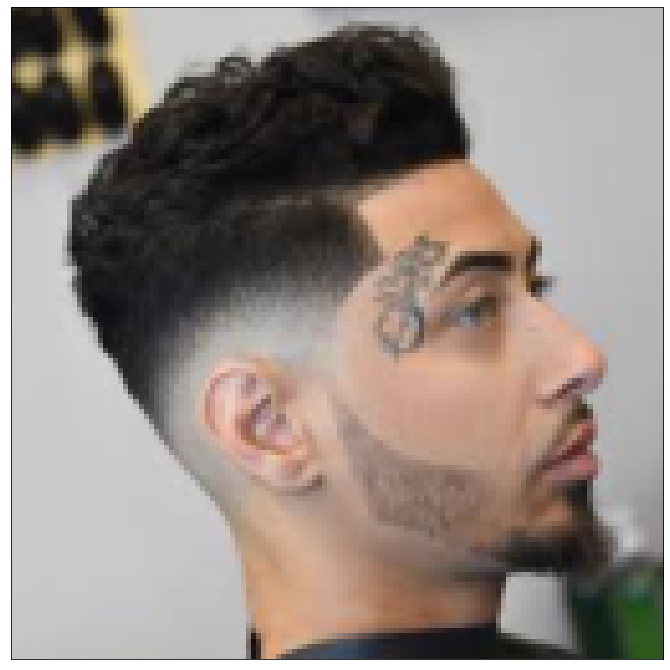

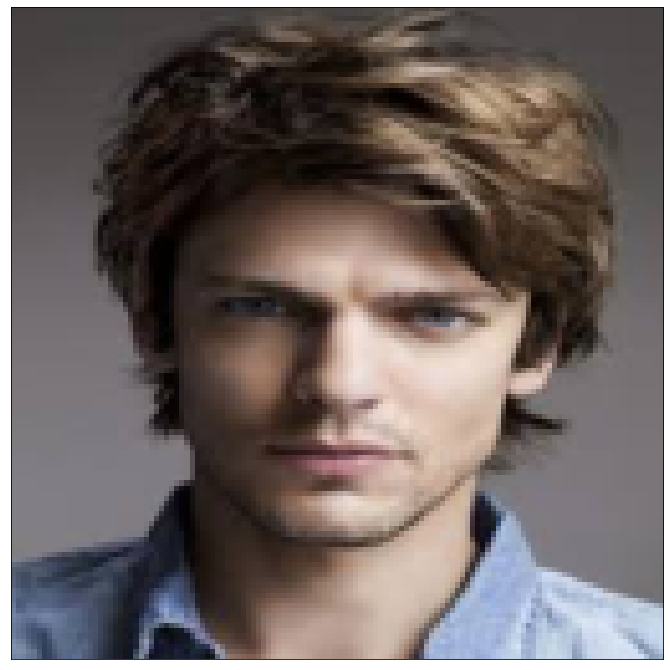

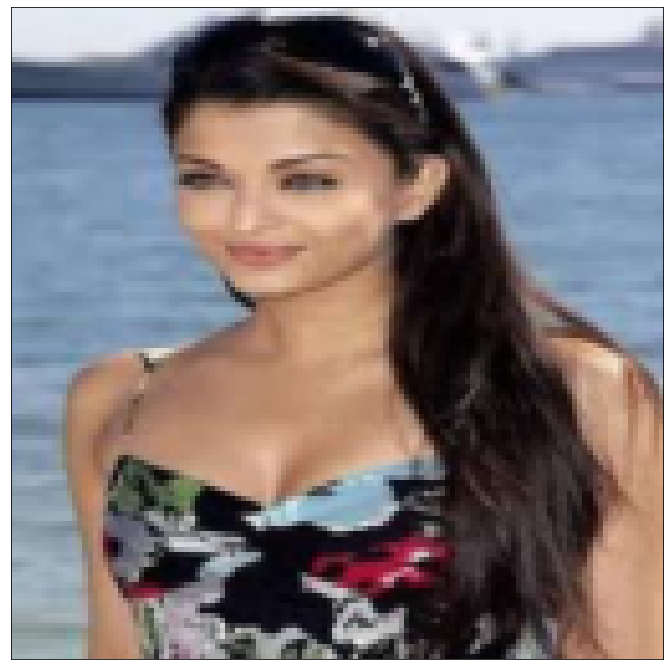

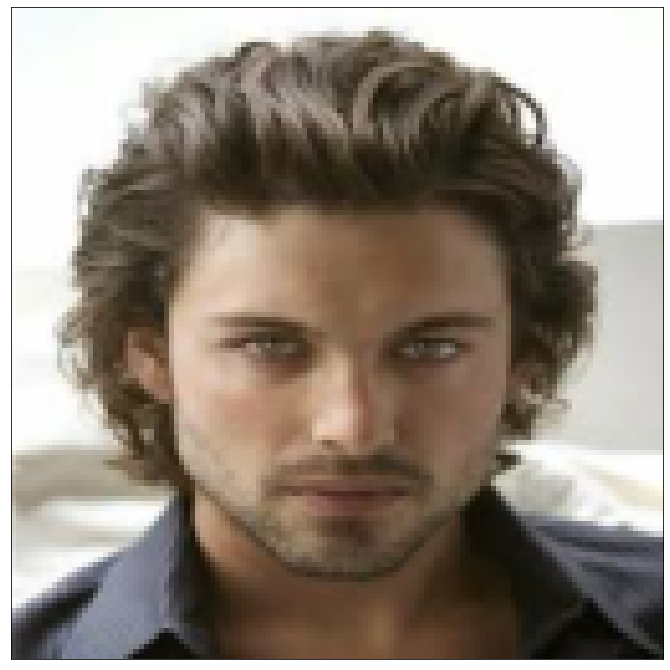

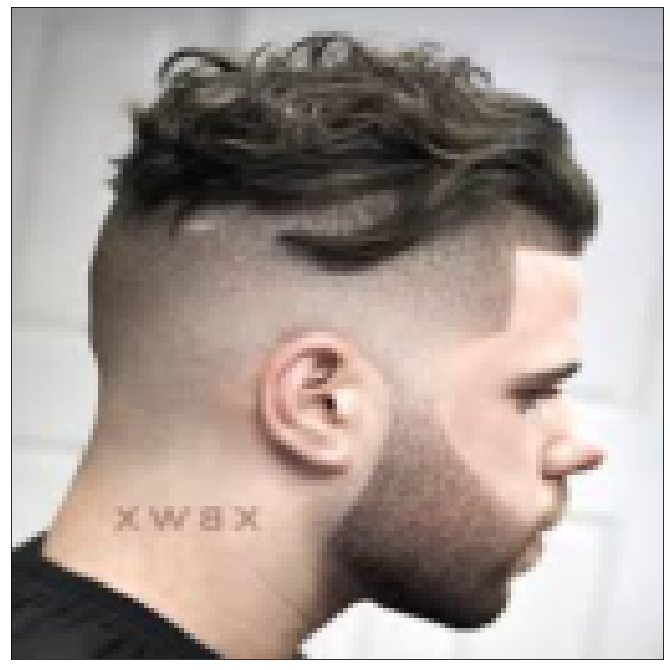

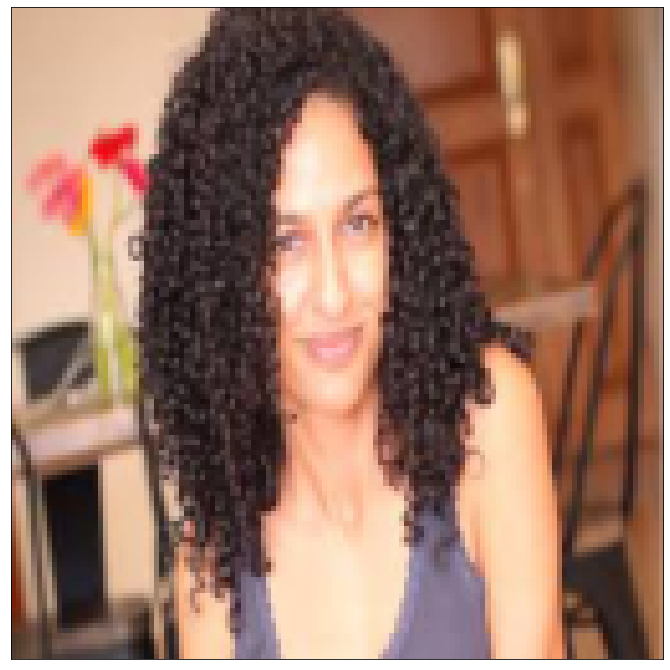

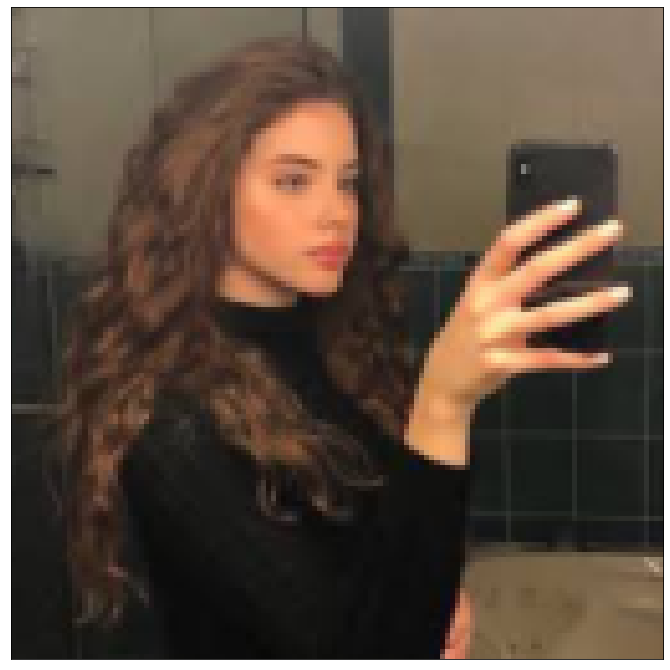

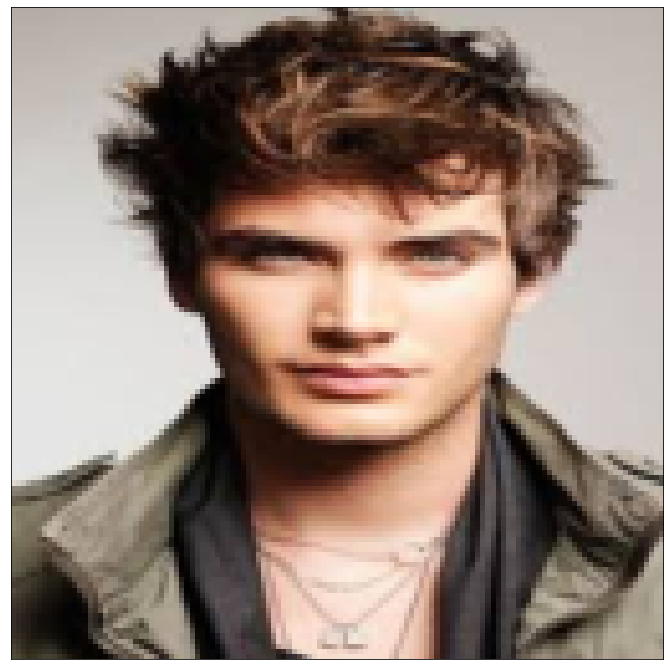

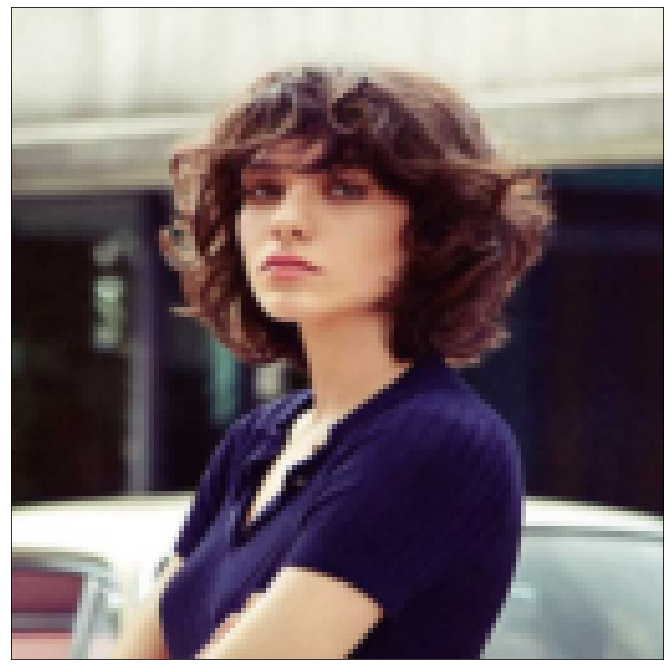

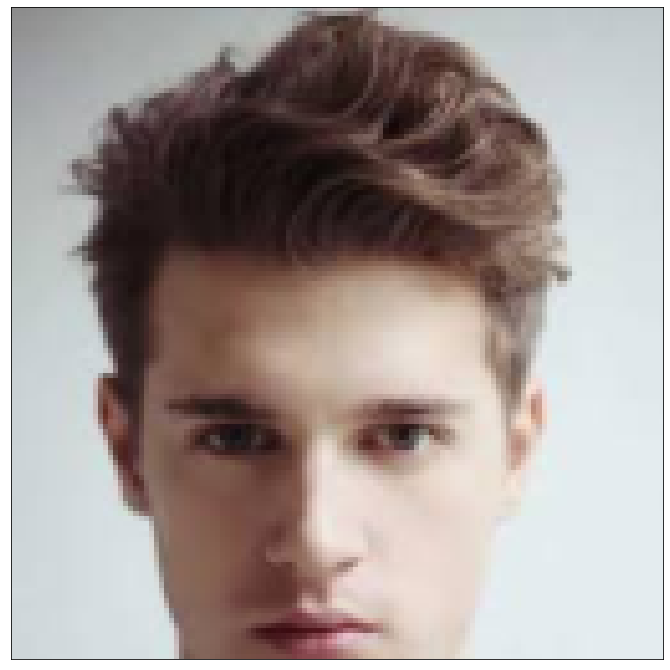

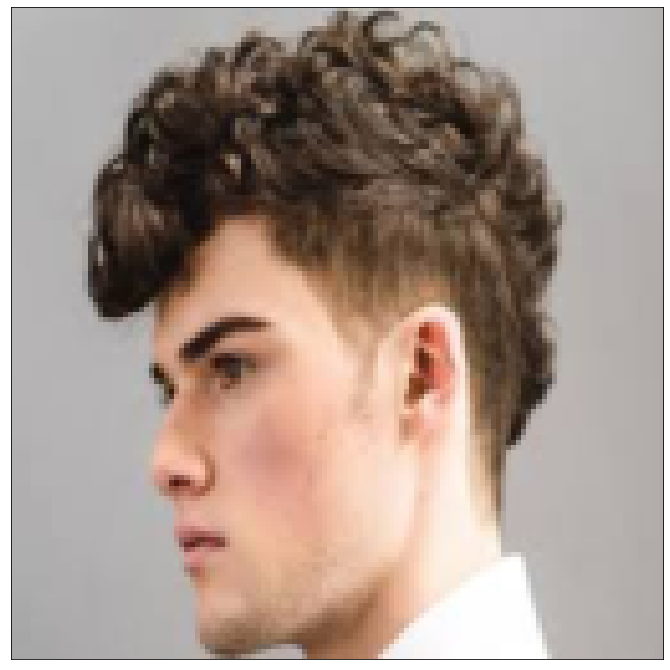

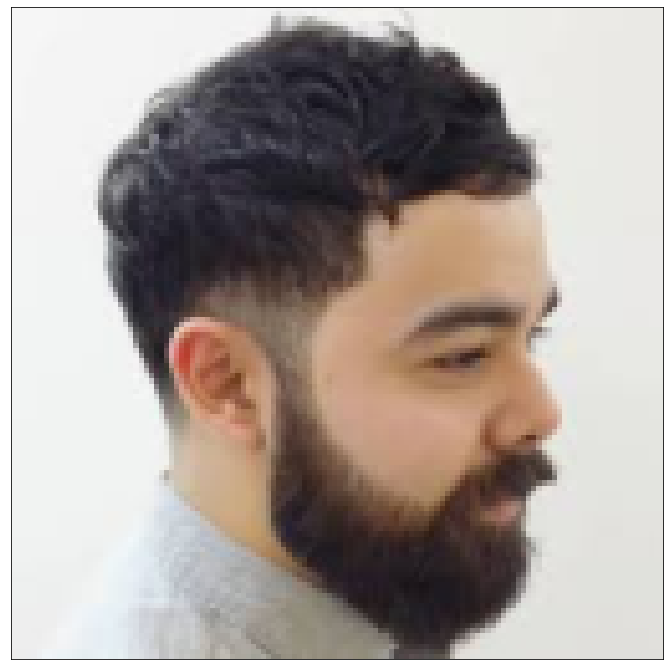

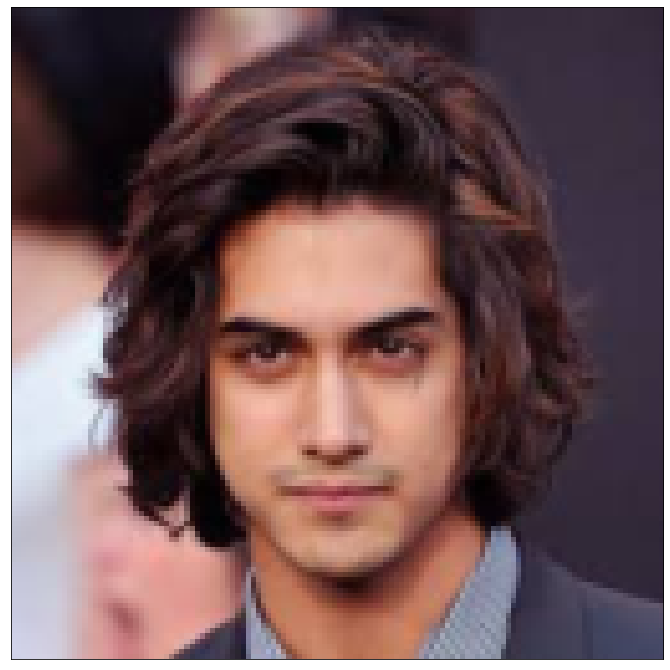

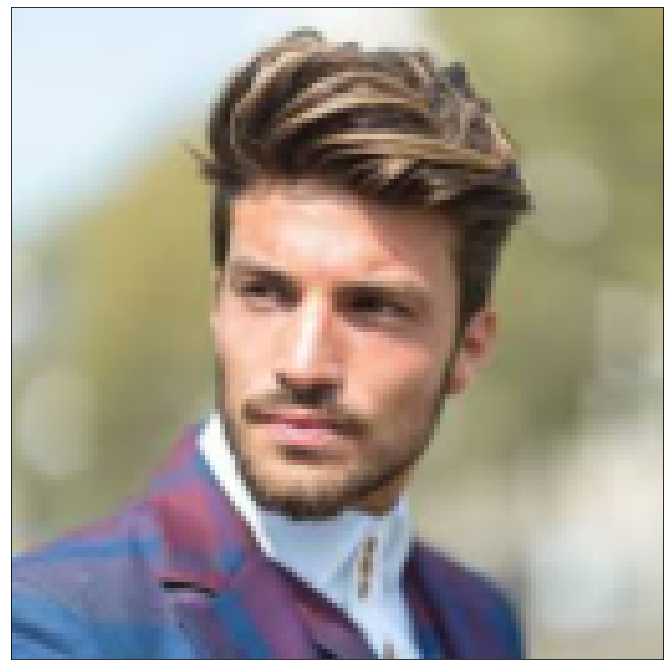

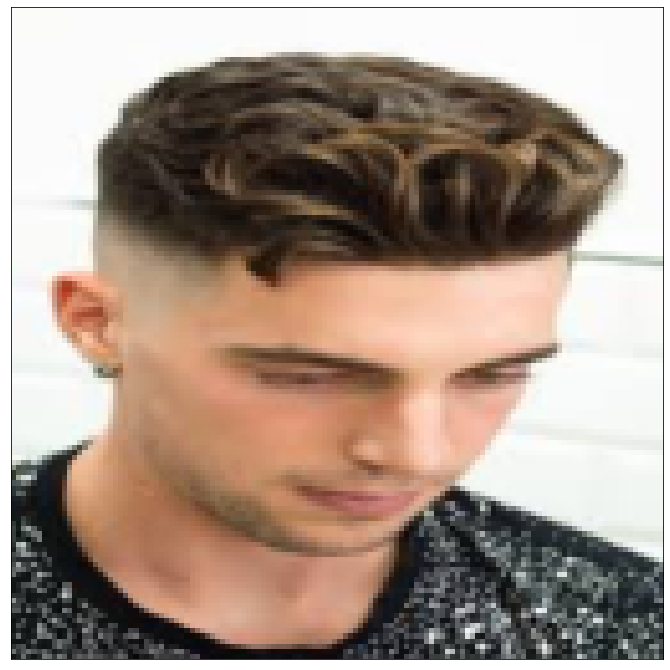

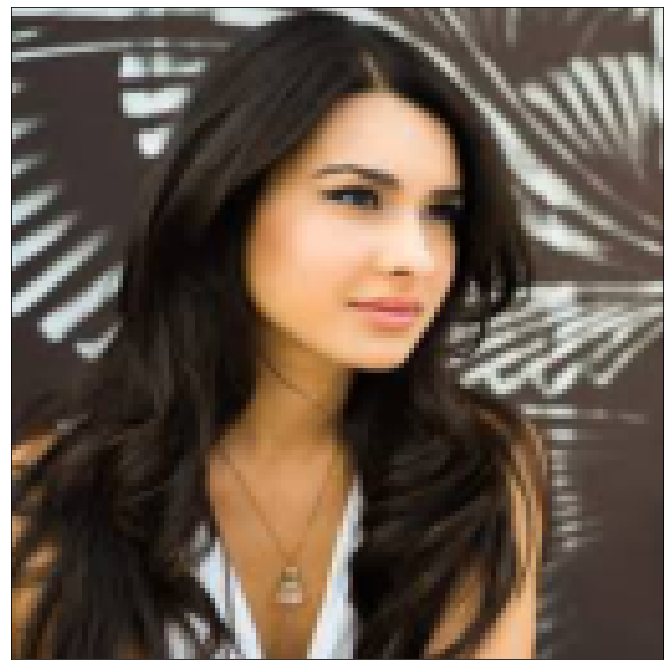

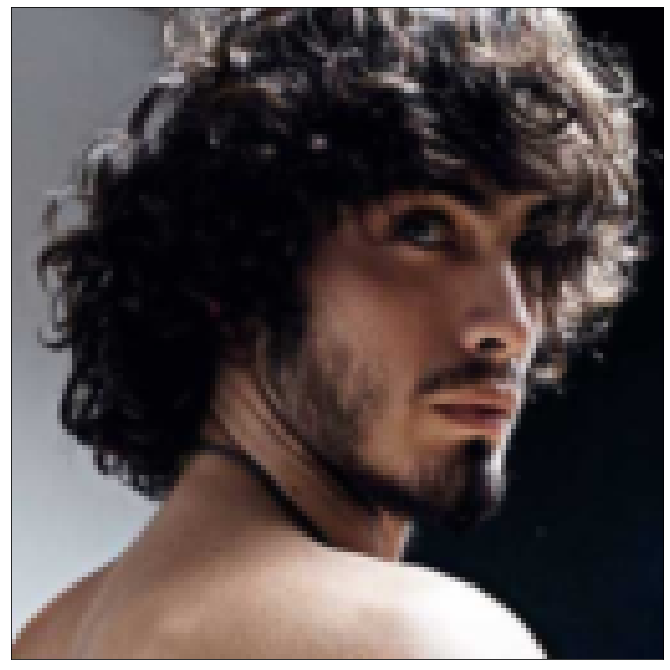

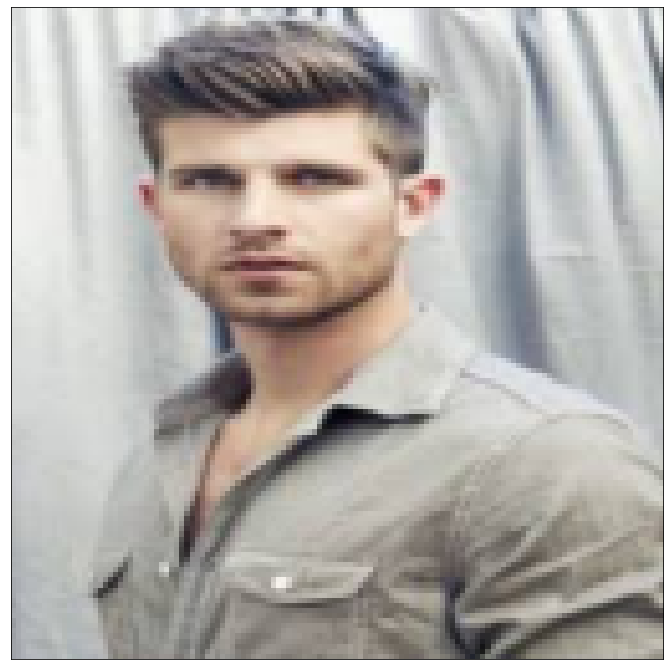

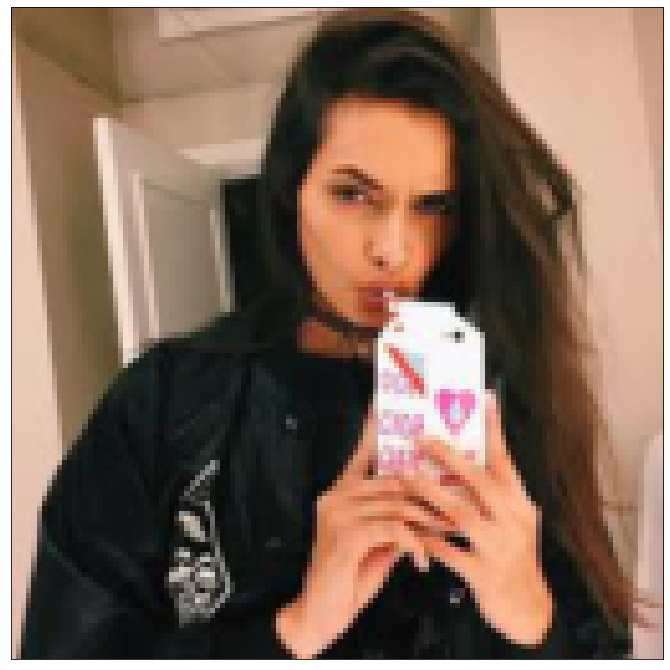

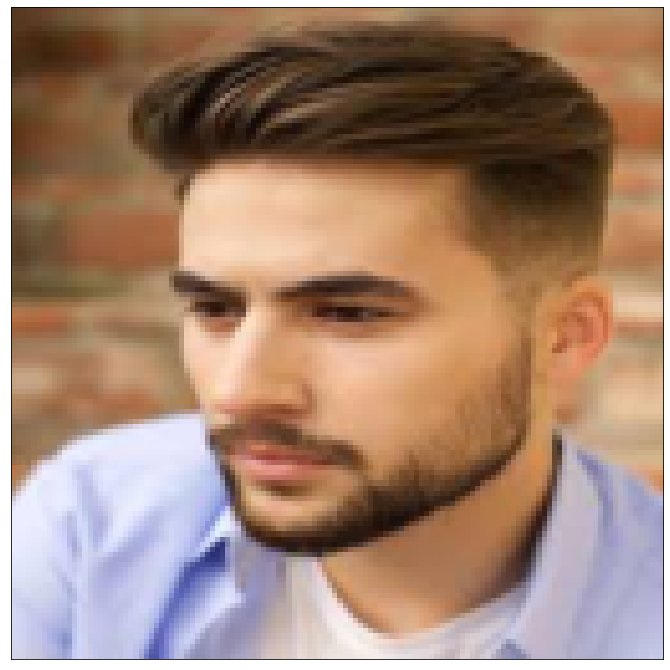

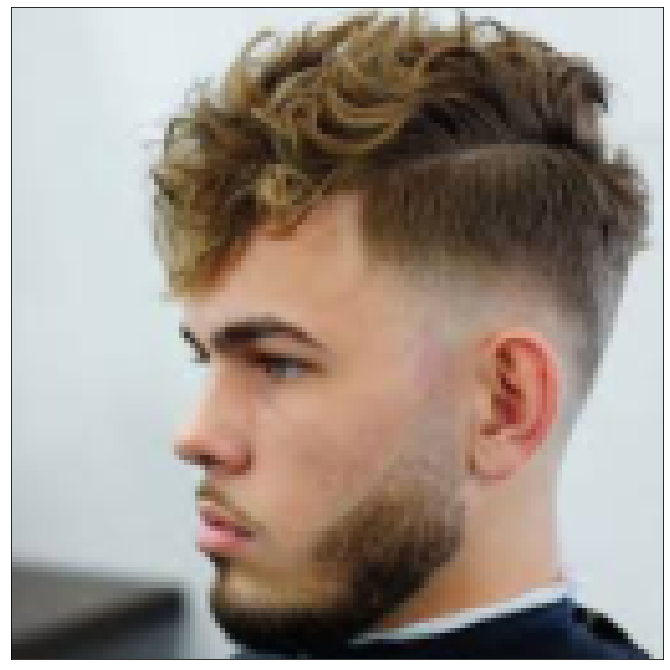

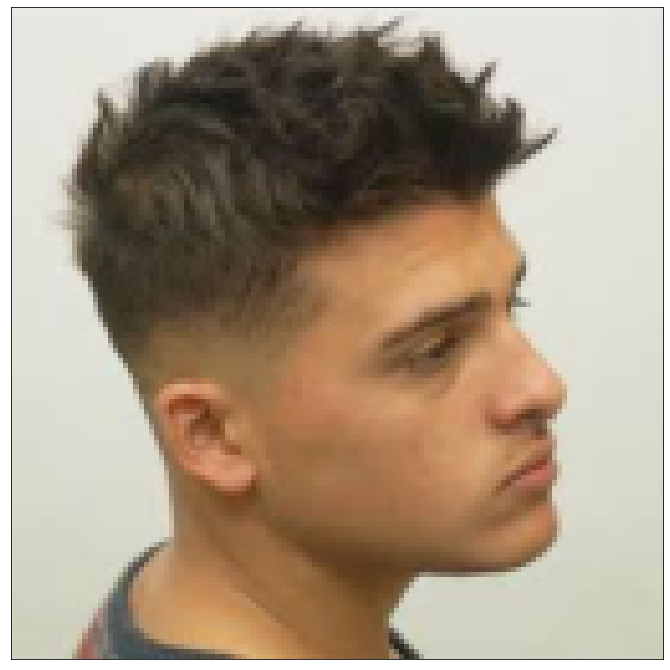

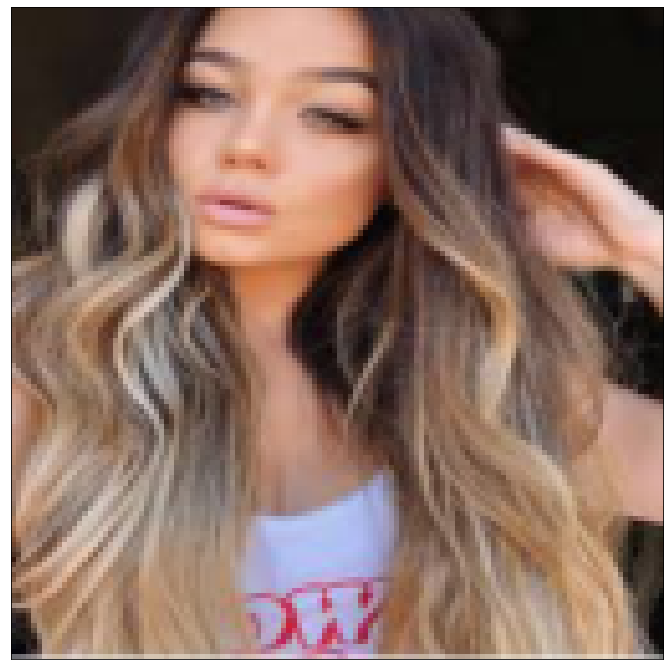

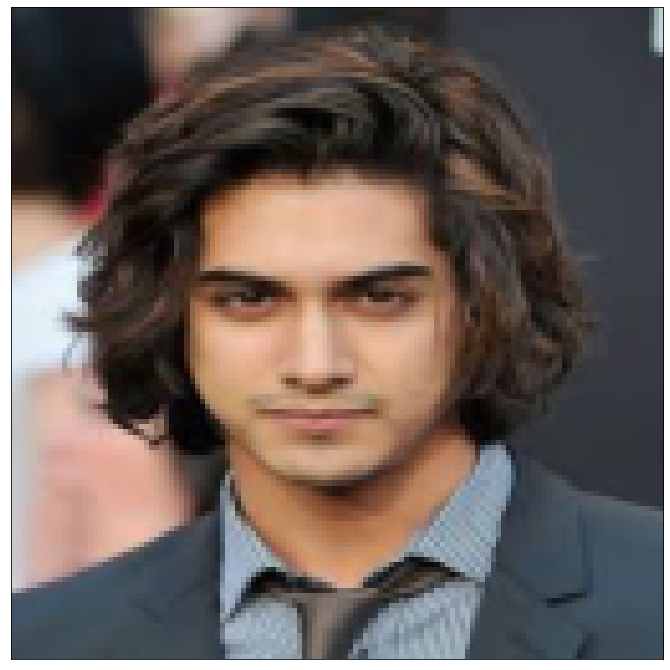

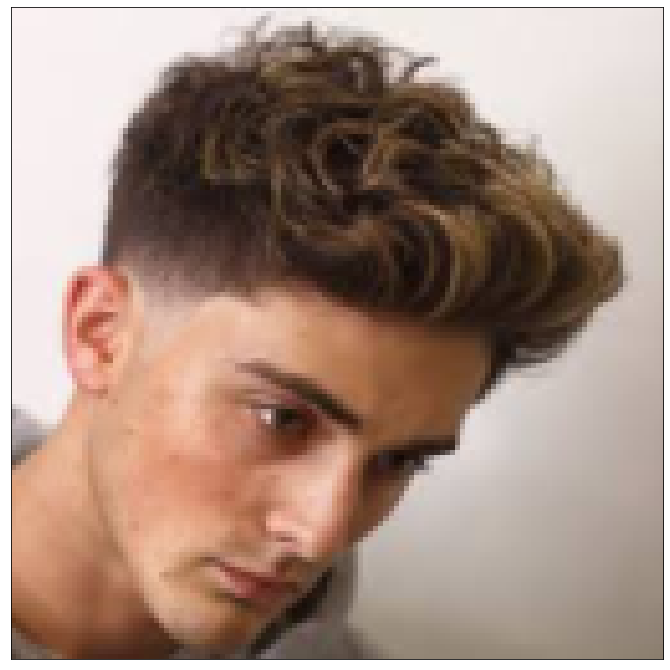

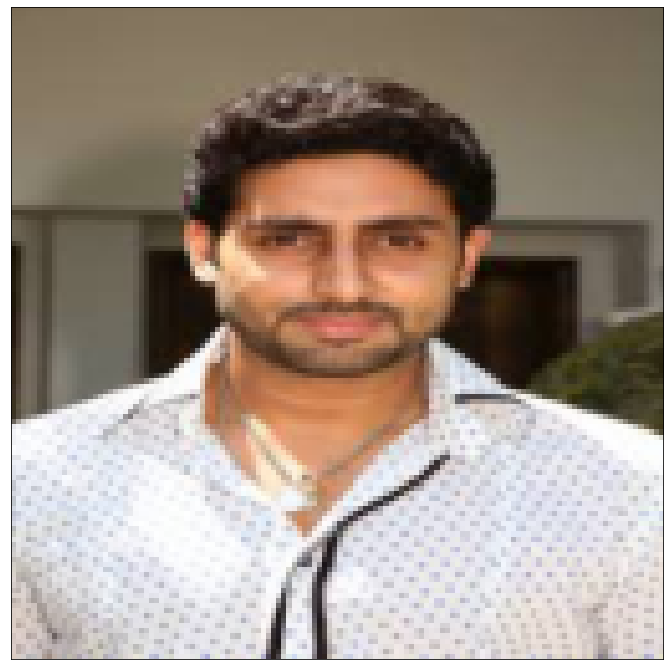

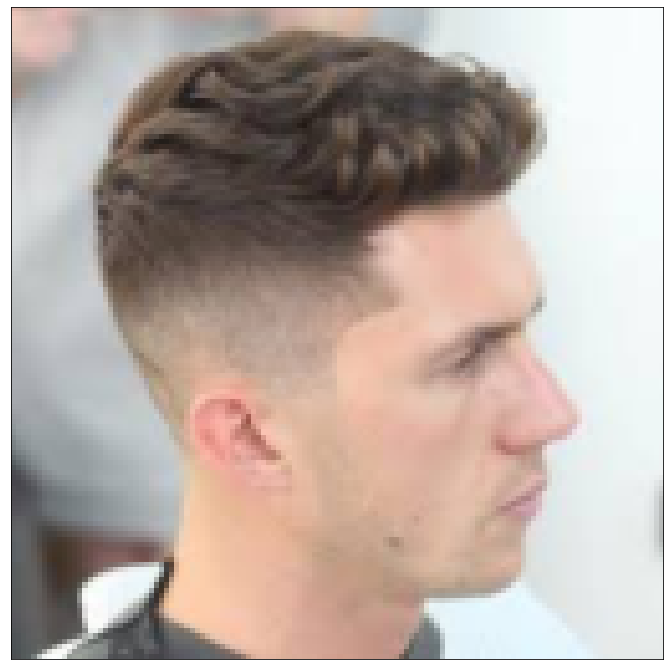

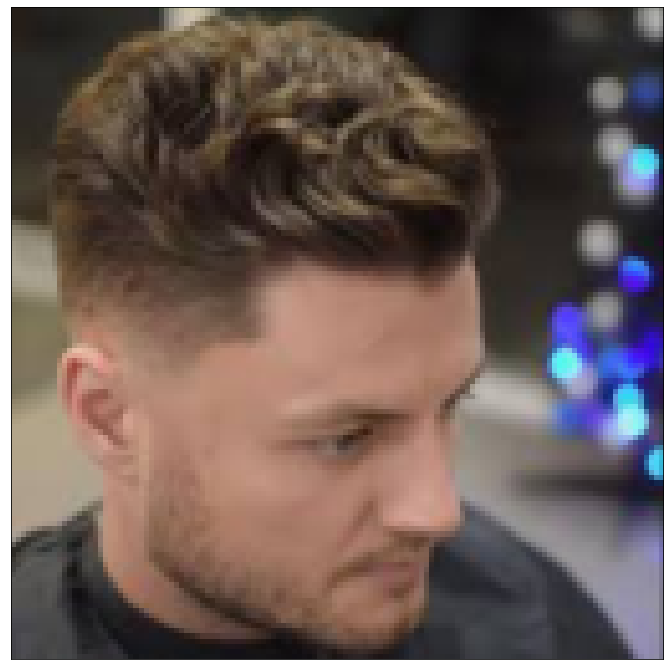

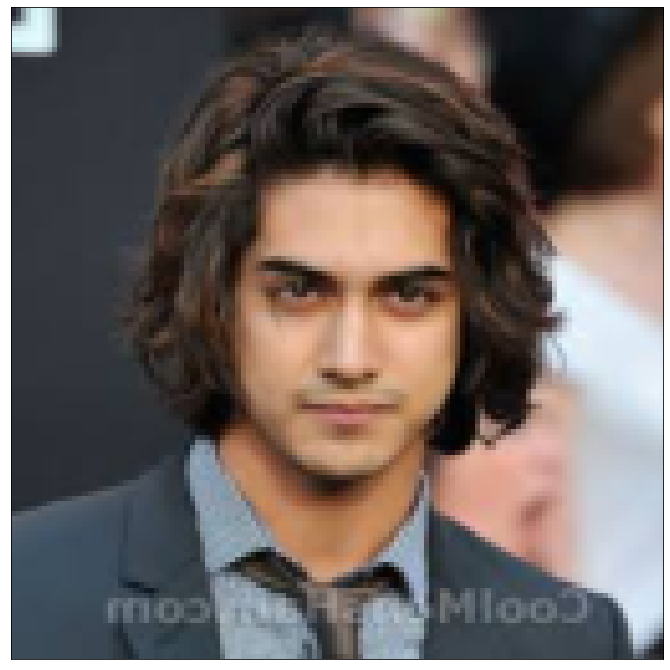

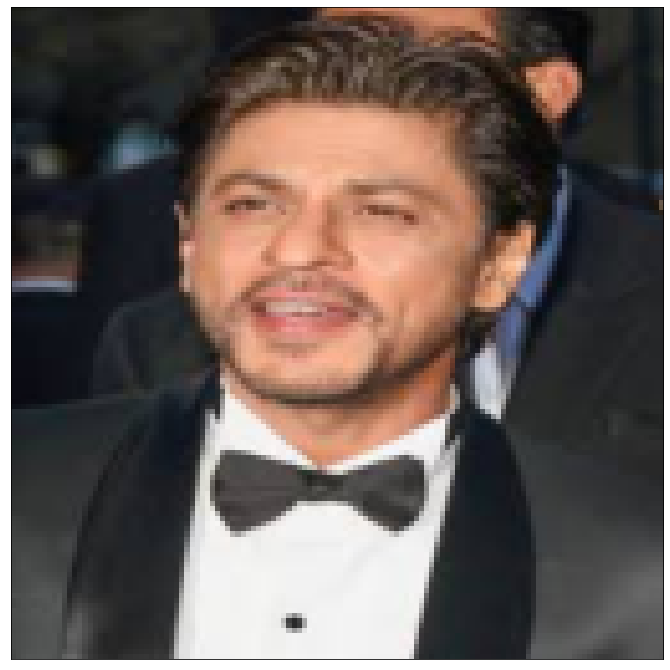

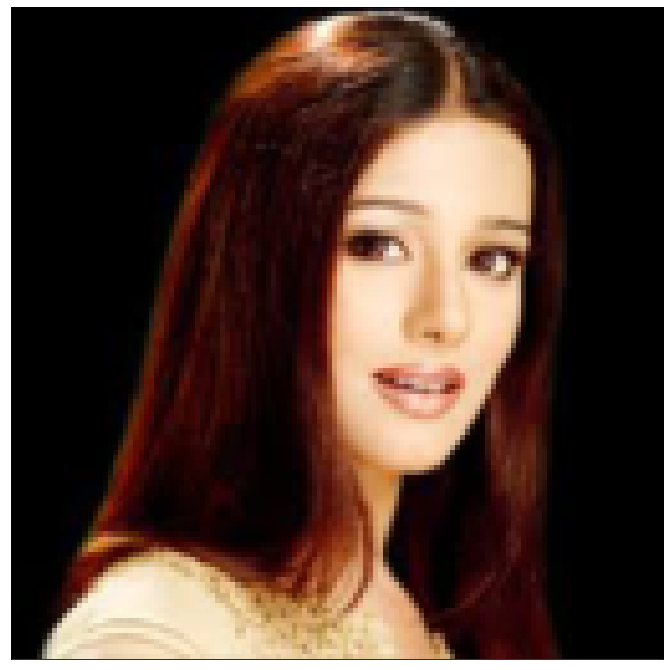

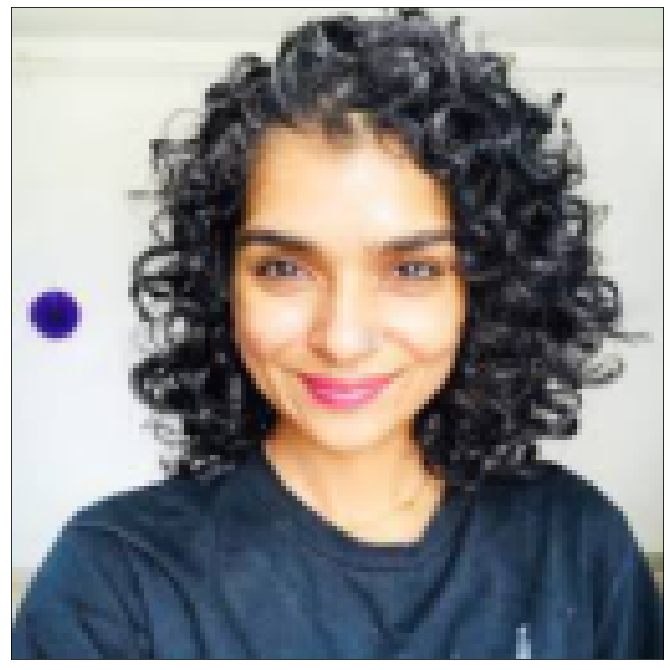

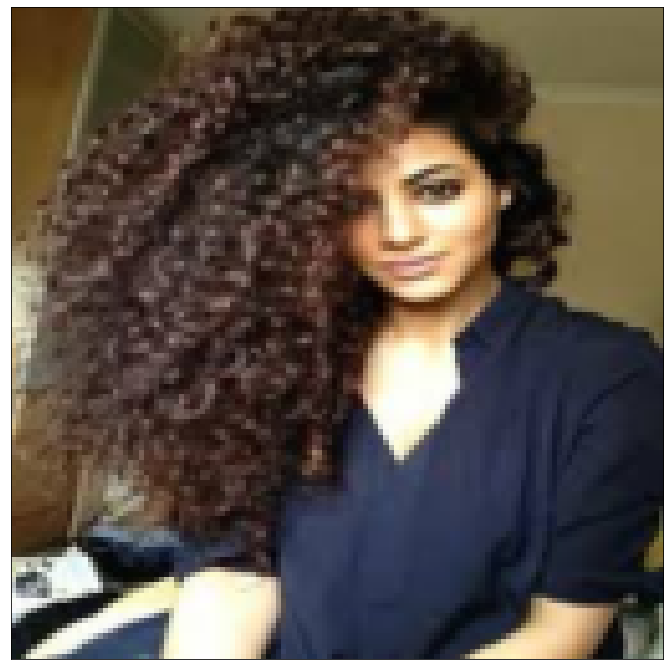

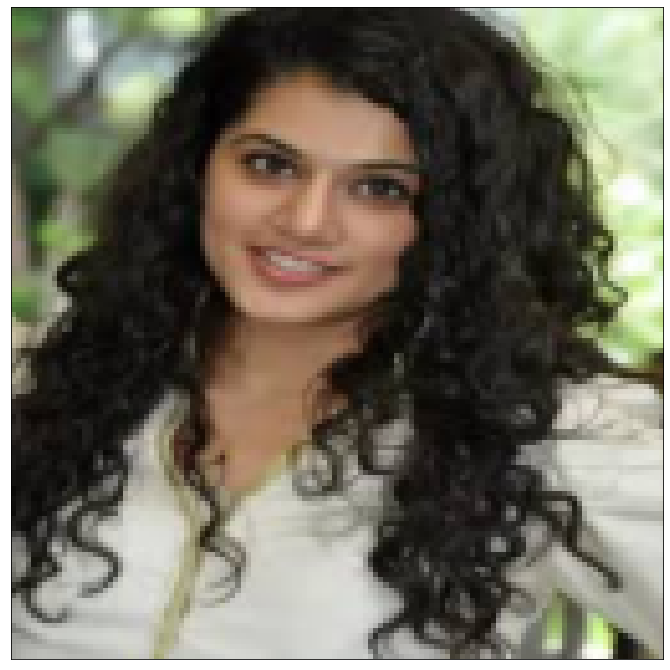

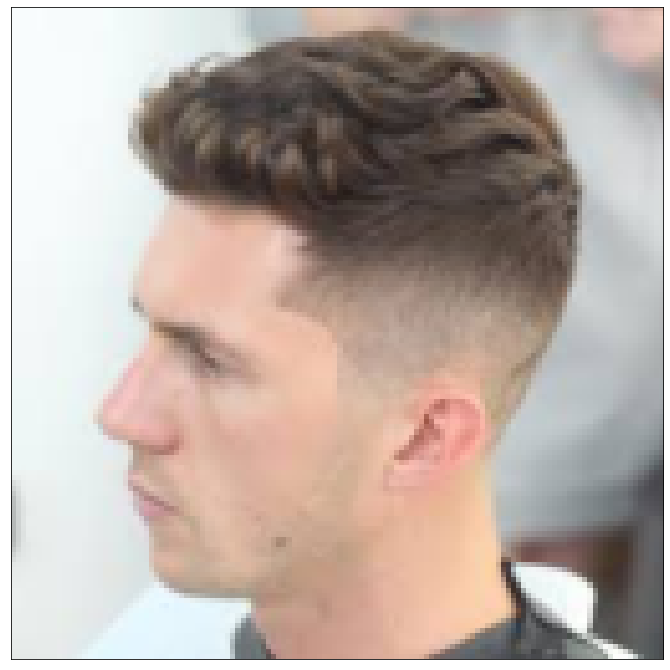

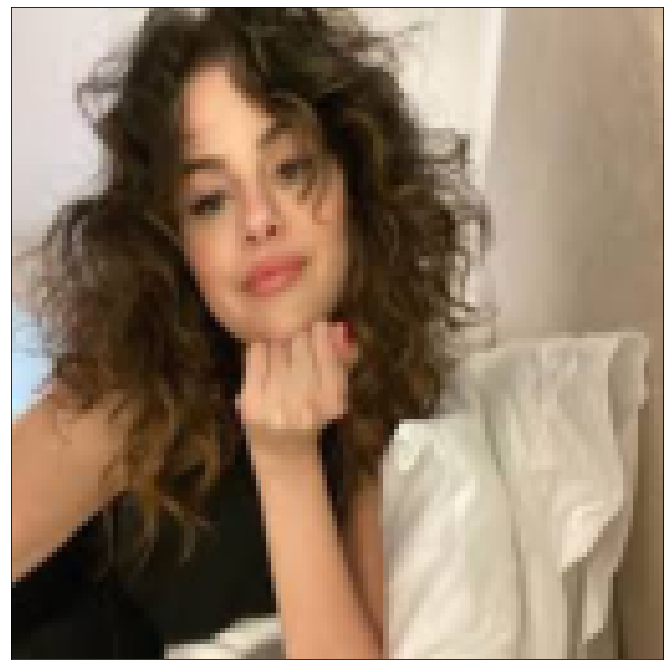

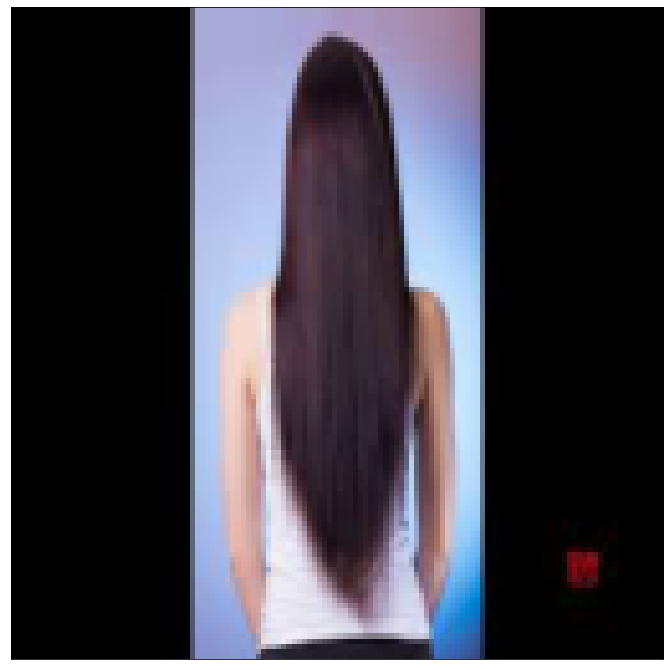

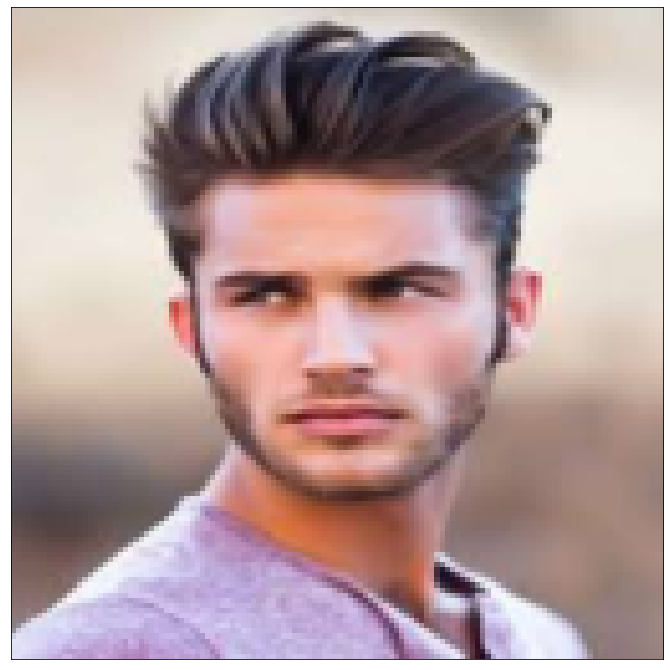

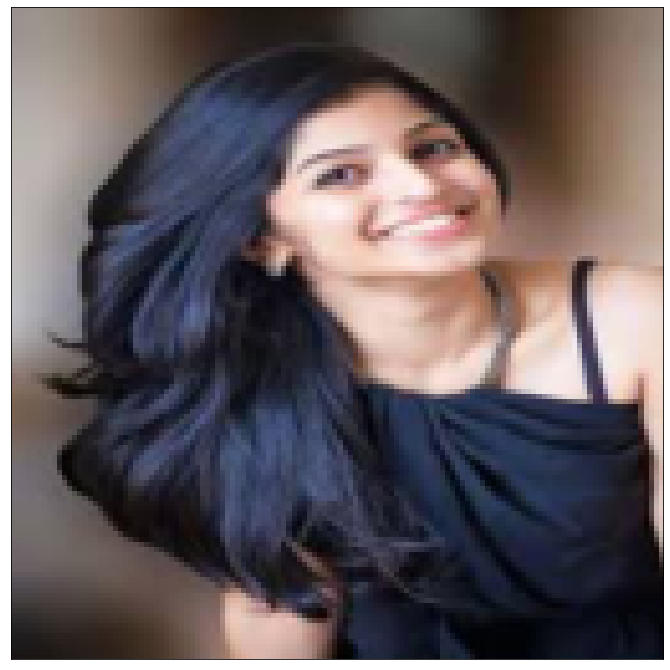

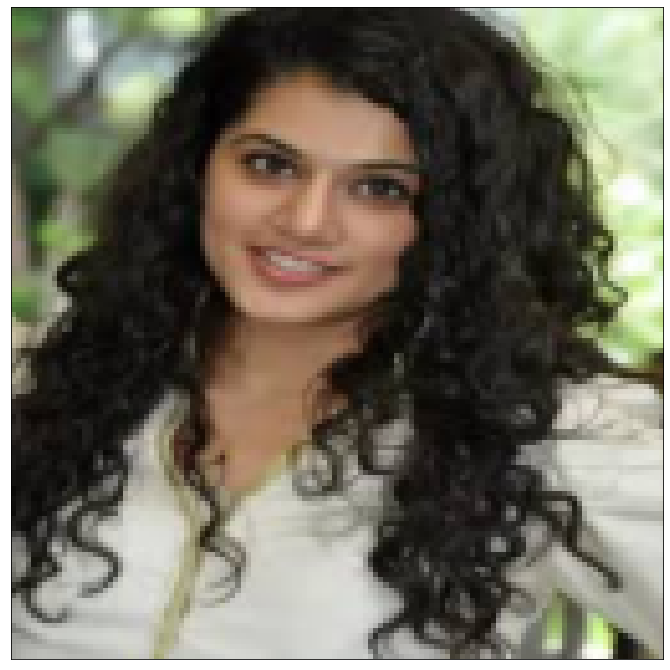

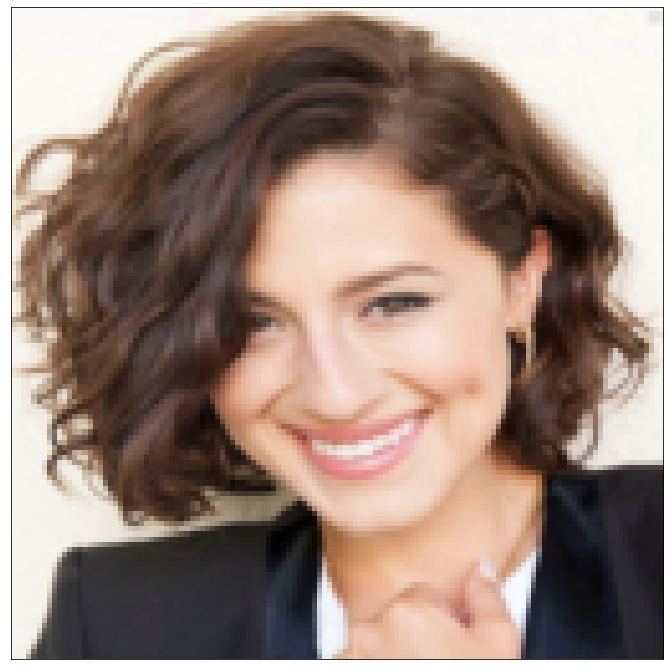

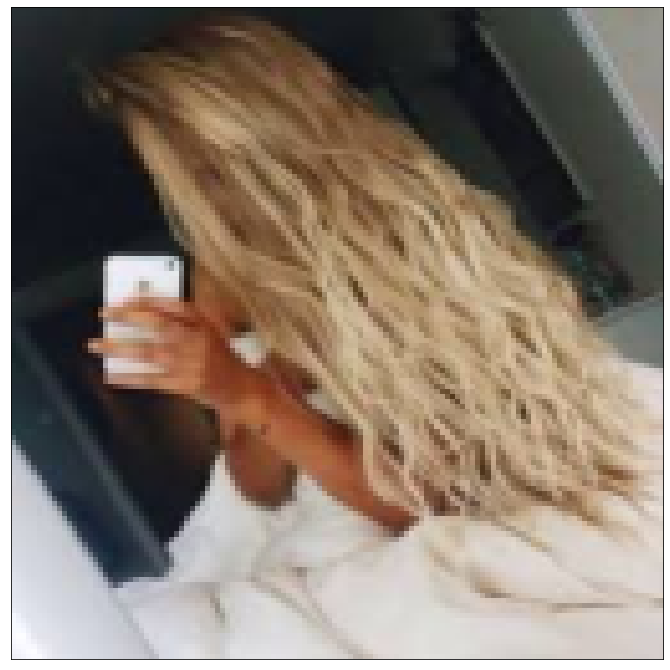

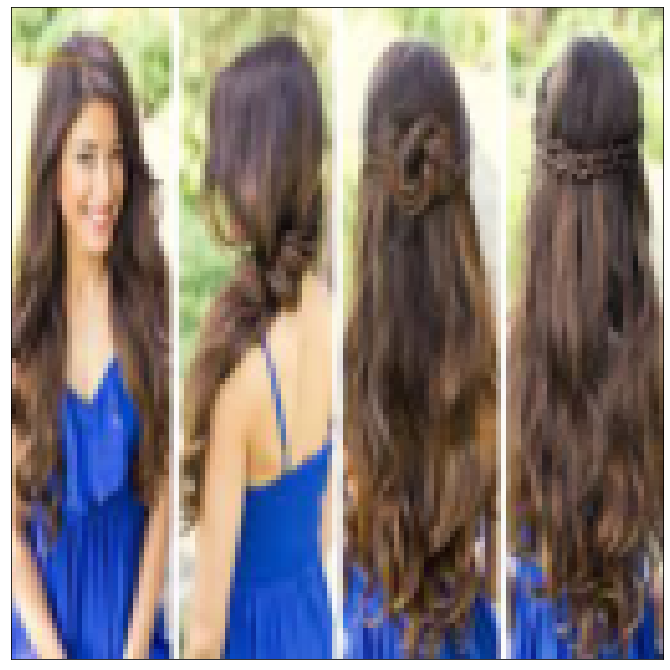

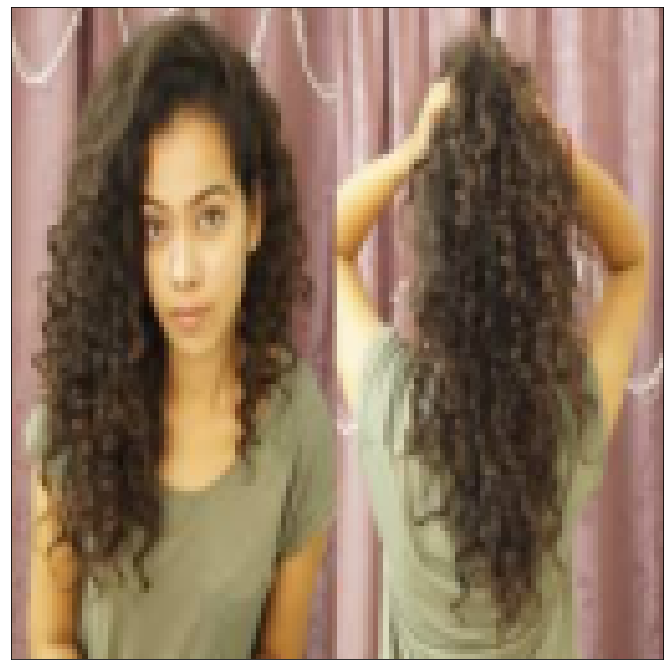

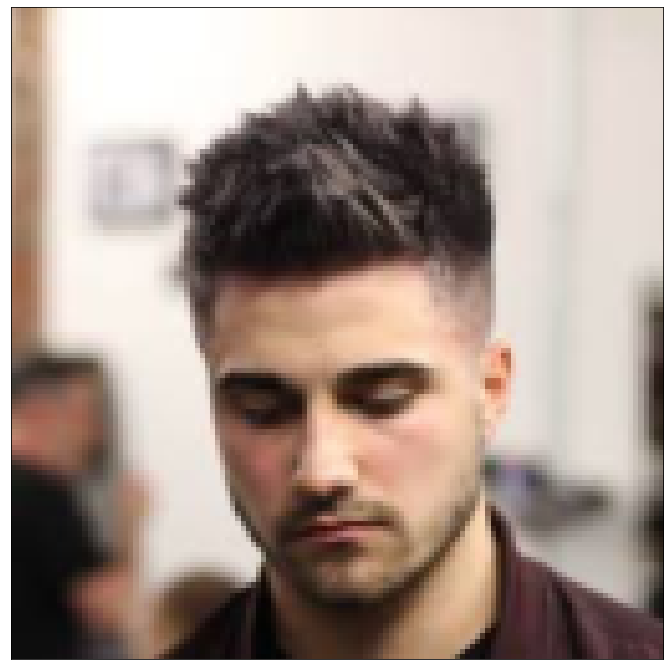

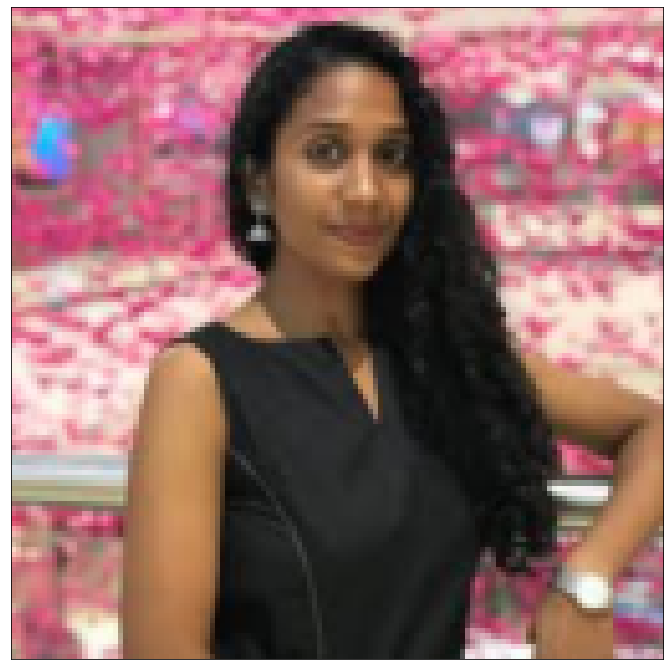

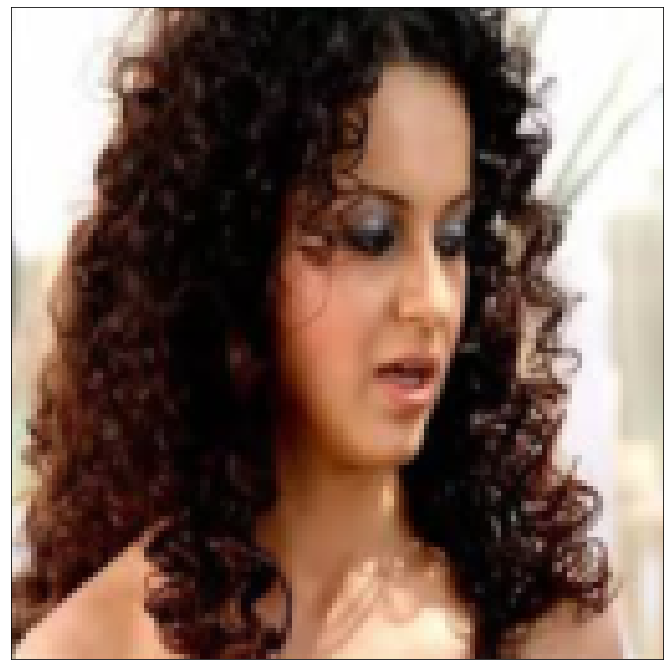

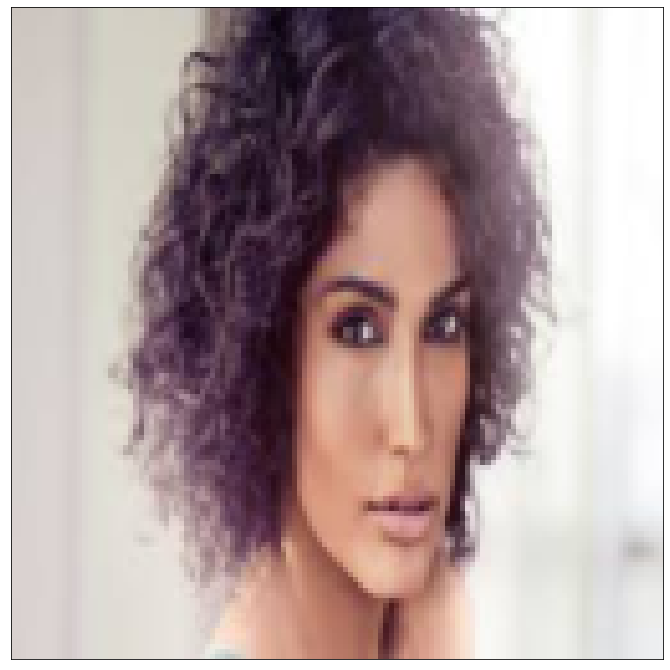

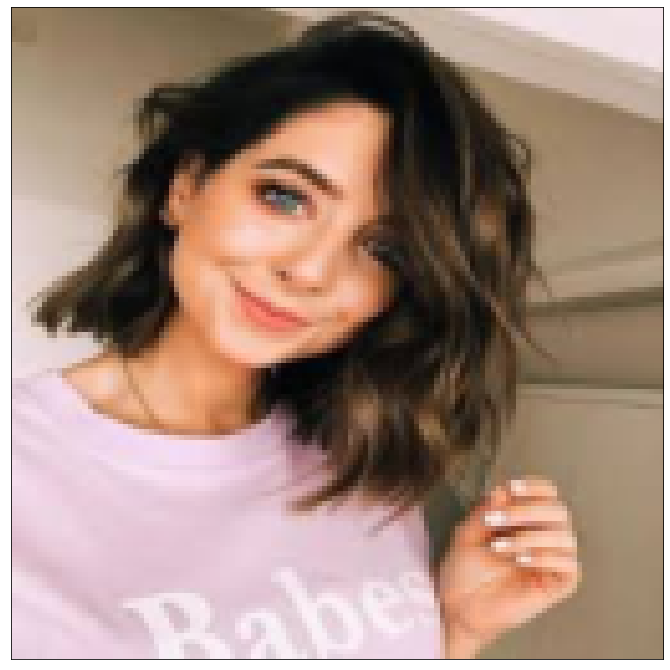

In [16]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from PIL import UnidentifiedImageError

def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        for img in images:
            try:
                # Attempt to display the image
                fig, ax = plt.subplots(figsize=(16, 12))
                ax.set_xticks([])
                ax.set_yticks([])
                ax.imshow(img.permute(1, 2, 0))
            except UnidentifiedImageError as e:
                # Skip the image and continue to the next one
                print("Caught UnidentifiedImageError:", e)
                continue
        break  # Only process one batch

# Usage
show_batch(train_dl)


In [17]:
class ImageClassification(nn.Module):

    def train_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)

        return {'val_loss': loss.detach(), 'val_acc': acc}


    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()  # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()  # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}


    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [18]:
class HairModelClassification(ImageClassification):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
        
            # Layer 1
            nn.Conv2d(3, 32, kernel_size=3, padding=(2, 2), stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=(2, 2), stride=2),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Dropout(0.5),
            
            # Layer 2
            nn.Conv2d(64, 128, kernel_size=3, padding=(2,2), stride=2),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=(2,2), stride=2),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Dropout(0.5),
            
            # layer 3
            nn.Conv2d(128, 128, kernel_size=3, padding=(2,2), stride=2),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Dropout(0.5),
            
            # Last layer
            nn.Flatten(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 3)            
        )
    def forward(self, xb):
        return self.network(xb)

In [19]:
model = HairModelClassification()

In [20]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):

    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):

        model.train()
        train_losses = []
        for batch in train_loader:
            try:
                loss = model.train_step(batch)
                train_losses.append(loss)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
            except UnidentifiedImageError as e:
                # Handle the error by printing a message
                print("Caught UnidentifiedImageError in training batch:", e)
                continue  # Skip this batch and continue to the next one


        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)

    return history

In [21]:
num_epochs = 70
opt_func = torch.optim.Adam
lr = 0.001

In [23]:
# Assuming you have defined 'model', 'train_dl', 'val_dl', 'num_epochs', 'lr', and 'opt_func'
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.1423, val_loss: 1.1532, val_acc: 0.1500
Epoch [1], train_loss: 1.1382, val_loss: 1.1462, val_acc: 0.1500
Epoch [2], train_loss: 1.1316, val_loss: 1.1289, val_acc: 0.1500
Epoch [3], train_loss: 1.1173, val_loss: 1.0839, val_acc: 0.4000
Epoch [4], train_loss: 1.0825, val_loss: 0.9968, val_acc: 0.6500
Epoch [5], train_loss: 1.0000, val_loss: 0.9227, val_acc: 0.6500
Epoch [6], train_loss: 1.0099, val_loss: 0.9249, val_acc: 0.6500
Epoch [7], train_loss: 1.0266, val_loss: 0.9252, val_acc: 0.6500
Epoch [8], train_loss: 1.0004, val_loss: 0.9571, val_acc: 0.6500
Epoch [9], train_loss: 1.0005, val_loss: 0.9823, val_acc: 0.6500
Epoch [10], train_loss: 0.9952, val_loss: 0.9903, val_acc: 0.6500
Epoch [11], train_loss: 1.0032, val_loss: 0.9811, val_acc: 0.6500
Epoch [12], train_loss: 0.9959, val_loss: 0.9619, val_acc: 0.6500
Epoch [13], train_loss: 0.9809, val_loss: 0.9376, val_acc: 0.6500
Epoch [14], train_loss: 0.9722, val_loss: 0.9243, val_acc: 0.6500
Epoch [15], train_lo

In [ ]:
print(history)

In [31]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report

# Define data paths
train_data_dir = 'C:/Users/dell/Hack/train'
test_data_dir = 'C:/Users/dell/Hack/test'

# Preprocessing and data augmentation
batch_size = 32
input_shape = (224, 224, 3)

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical'
)

# Build the model
def build_model(input_shape, num_classes):
    input_layer = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu')(input_layer)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    output_layer = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    return model

model = build_model(input_shape, num_classes=3)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
num_epochs = 10
model.fit(train_generator, epochs=num_epochs)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Save the trained model
model.save('hair_type_model.h5')


Found 79 images belonging to 3 classes.
Found 36 images belonging to 3 classes.
Epoch 1/10
3/3 [==============================] - 9s 2s/step - loss: 28.4042 - accuracy: 0.5570
Epoch 2/10
3/3 [==============================] - 6s 2s/step - loss: 11.1175 - accuracy: 0.3418
Epoch 3/10
3/3 [==============================] - 6s 2s/step - loss: 2.9919 - accuracy: 0.5570
Epoch 4/10
3/3 [==============================] - 6s 1s/step - loss: 1.8538 - accuracy: 0.6076
Epoch 5/10
3/3 [==============================] - 6s 1s/step - loss: 0.9976 - accuracy: 0.6962
Epoch 6/10
3/3 [==============================] - 6s 2s/step - loss: 1.0144 - accuracy: 0.7342
Epoch 7/10
3/3 [==============================] - 6s 2s/step - loss: 0.7598 - accuracy: 0.7342
Epoch 8/10
3/3 [==============================] - 6s 1s/step - loss: 0.6320 - accuracy: 0.7848
Epoch 9/10
3/3 [==============================] - 6s 2s/step - loss: 0.4502 - accuracy: 0.8354
Epoch 10/10
2/2 [==============================] - 3s 89ms/step

In [ ]:
!pip install Flask
